# Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import cv2
from PIL import Image
import re
import tifffile as tiff
import albumentations as A



# Read the dataset

In [32]:
def normalize(array):
    array = array.astype(float)
    if array.max() == array.min():
        return np.zeros_like(array)   # or just return array
    return (array - array.min()) / (array.max() - array.min())


# Function to display image and mask side by side
def display_image_and_mask(img_path, mask_path):
    img = tiff.imread(img_path)
    mask = np.array(Image.open(mask_path))

    # Pick bands for RGB composite (example: [Red=3, Green=2, Blue=1])
    r = normalize(img[:,:,3])
    g = normalize(img[:,:,2])
    b = normalize(img[:,:,1])

    # Create RGB composite
    rgb = np.dstack((r, g, b))

    # Plot the image and the mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(rgb)
    axes[0].set_title('Image (RGB composite)')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask (Water=1, Non-water=0)')
    axes[1].axis('off')

    plt.show()



In [4]:
train_img_dir = "/content/drive/MyDrive/Data/data/images"
train_mask_dir = "/content/drive/MyDrive/Data/data/labels"

In [ ]:
train_img_files =os.listdir(train_img_dir)
train_mask_files = os.listdir(train_mask_dir)

print(len(train_img_files))
print(len(train_mask_files))

# drop mask that contaion '_'
train_mask_files = [f for f in os.listdir(train_mask_dir) if "_" not in f]

print("After filtering:", len(train_mask_files))


306
456
After filtering: 306


In [6]:
def natural_sort(l):
    return sorted(l, key=lambda x: [int(t) if t.isdigit() else t for t in re.split(r'(\d+)', x)])

train_img_files = natural_sort(train_img_files)
train_mask_files = natural_sort(train_mask_files)

print(train_img_files[:10])
print(train_mask_files[:10])

['0.tif', '1.tif', '2.tif', '3.tif', '4.tif', '5.tif', '6.tif', '7.tif', '8.tif', '9.tif']
['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png']


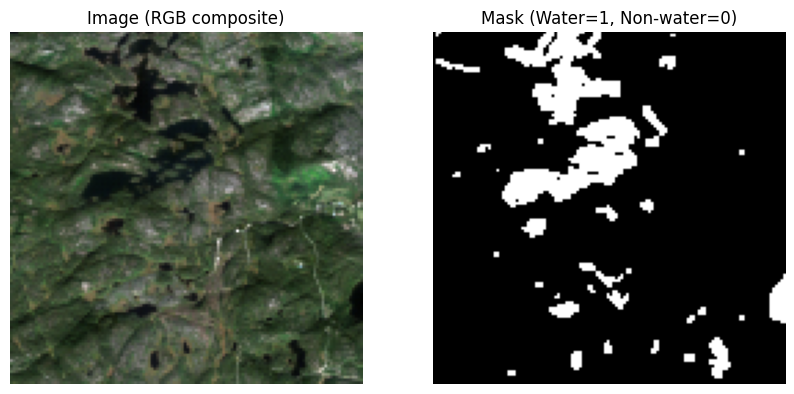

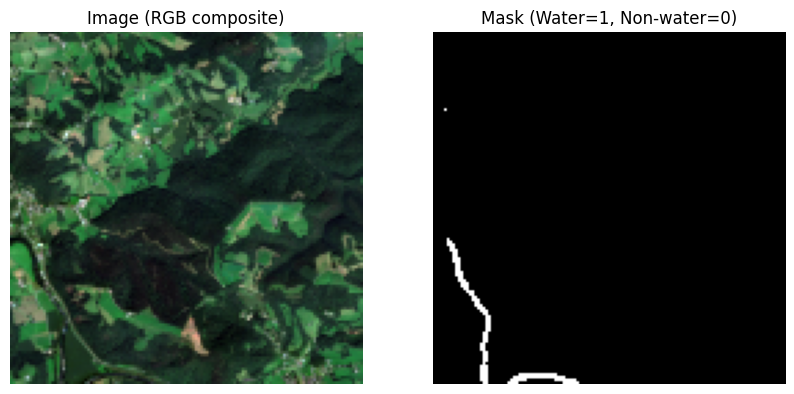

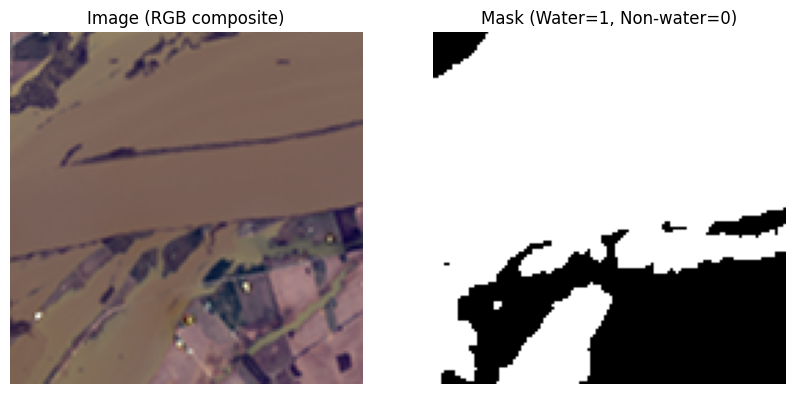

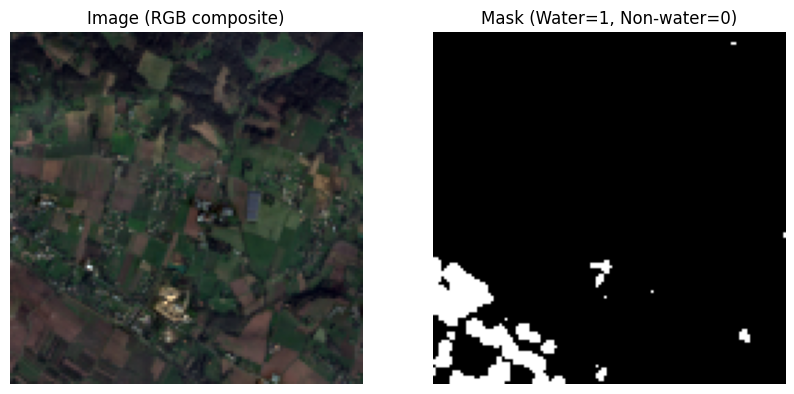

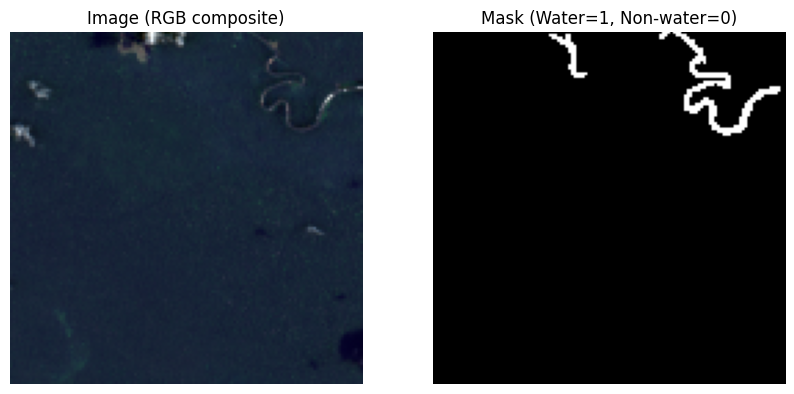

In [7]:
for img_file, mask_file in zip(train_img_files[:5], train_mask_files[:5]):
    # Construct the full file paths
    img_path = os.path.join(train_img_dir, img_file)
    mask_path = os.path.join(train_mask_dir, mask_file)

    # Display the image and mask together
    display_image_and_mask(img_path, mask_path)


# Prepare Training & Validation Data

In [33]:
# Get full paths of images and masks
images = []
masks  = []

for img_file, mask_file in zip(train_img_files, train_mask_files):
    # Construct the full file paths
    img_path = os.path.join(train_img_dir, img_file)
    mask_path = os.path.join(train_mask_dir, mask_file)

    images.append(img_path)
    masks.append(mask_path)


print("Total images:", len(images))
print("Total masks:", len(masks))
print("First 5 image paths:", images[:5])
print("First 5 mask paths:", masks[:5])


Total images: 306
Total masks: 306
First 5 image paths: ['/content/drive/MyDrive/Data/data/images/0.tif', '/content/drive/MyDrive/Data/data/images/1.tif', '/content/drive/MyDrive/Data/data/images/2.tif', '/content/drive/MyDrive/Data/data/images/3.tif', '/content/drive/MyDrive/Data/data/images/4.tif']
First 5 mask paths: ['/content/drive/MyDrive/Data/data/labels/0.png', '/content/drive/MyDrive/Data/data/labels/1.png', '/content/drive/MyDrive/Data/data/labels/2.png', '/content/drive/MyDrive/Data/data/labels/3.png', '/content/drive/MyDrive/Data/data/labels/4.png']


In [34]:
data = pd.DataFrame({"image": images, "mask": masks})

train_df, val_df = train_test_split(data, train_size=0.8, shuffle=True, random_state=123)

In [35]:
train_df.head()

,image,mask
203,/content/drive/MyDrive/Data/data/images/203.tif,/content/drive/MyDrive/Data/data/labels/203.png
232,/content/drive/MyDrive/Data/data/images/232.tif,/content/drive/MyDrive/Data/data/labels/232.png
35,/content/drive/MyDrive/Data/data/images/35.tif,/content/drive/MyDrive/Data/data/labels/35.png
249,/content/drive/MyDrive/Data/data/images/249.tif,/content/drive/MyDrive/Data/data/labels/249.png
161,/content/drive/MyDrive/Data/data/images/161.tif,/content/drive/MyDrive/Data/data/labels/161.png


In [36]:
# Define augmentation pipeline
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [37]:
def custom_generator(image_paths, mask_paths, batch_size=32, img_size=(128,128), n_channels=12, augment=True):
    while True:
        idxs = np.arange(len(image_paths))
        np.random.shuffle(idxs)

        for i in range(0, len(idxs), batch_size):
            batch_idx = idxs[i:i+batch_size]
            batch_img_paths = [image_paths[j] for j in batch_idx]
            batch_mask_paths = [mask_paths[j] for j in batch_idx]

            X = np.zeros((len(batch_img_paths), *img_size, n_channels), dtype=np.float32)
            y = np.zeros((len(batch_mask_paths), *img_size, 1), dtype=np.float32)

            for k, (img_path, mask_path) in enumerate(zip(batch_img_paths, batch_mask_paths)):
                # Read image
                img = tiff.imread(img_path)

                # Resize each channel separately
                resized = np.zeros((*img_size, n_channels), dtype=np.float32)
                for c in range(n_channels):
                    resized[:,:,c] = cv2.resize(img[:,:,c], img_size, interpolation=cv2.INTER_LINEAR)
                img = resized

                # Normalize
                for c in range(img.shape[-1]):
                    img[:,:,c] = normalize(img[:,:,c])

                # Read mask
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
                mask = (mask > 0).astype(np.float32)
                mask = np.expand_dims(mask, axis=-1)

                # Augmentation
                if augment:
                    augmented = augmentations(image=img, mask=mask)
                    img, mask = augmented['image'], augmented['mask']

                X[k] = img
                y[k] = mask

            yield X, y


In [38]:
# Training generator (with augmentation)
train_gen = custom_generator(
    train_df["image"].values,
    train_df["mask"].values,
    batch_size=32,
    img_size=(128,128),
    n_channels=12,
    augment=True
)

# Validation generator (without augmentation)
val_gen = custom_generator(
    val_df["image"].values,
    val_df["mask"].values,
    batch_size=32,
    img_size=(128,128),
    n_channels=12,
    augment=False
)


In [39]:
X_batch, y_batch = next(train_gen)
print("X batch shape:", X_batch.shape)
print("y batch shape:", y_batch.shape)


X batch shape: (32, 128, 128, 12)
y batch shape: (32, 128, 128, 1)


# Build & Train the model

In [ ]:
def unet_model(input_size=(128, 128, 12)):
    inputs = Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output: 1 channel mask, sigmoid for binary segmentation
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [41]:
# Build the model for 12 channels
model = unet_model(input_size=(128, 128, 12))

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_38[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_40[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_42[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 16, 16,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_10… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_44[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 8, 8, 512) │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_11… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_46[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 16, 16,    │  2,097,664 │ conv2d_47[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # threshold
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Re-compile model with better metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric, dice_coef])


In [43]:
checkpoint = ModelCheckpoint(
    "best_model.h5",            # file to save
    monitor="val_loss",         # metric to monitor
    verbose=1,                  # print when model is saved
    save_best_only=True,        # keep only the best
    mode="min"                  # "min" because lower val_loss is better
)


In [44]:
# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_df)//32,
    validation_steps=len(val_df)//32,
    epochs=75,
    callbacks=[checkpoint]
)



Epoch 1/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6917 - dice_coef: 0.2293 - iou_metric: 0.1479 - loss: 0.5969   
Epoch 1: val_loss improved from inf to 0.37241, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.6988 - dice_coef: 0.2377 - iou_metric: 0.1547 - loss: 0.5885 - val_accuracy: 0.8968 - val_dice_coef: 0.7486 - val_iou_metric: 0.5982 - val_loss: 0.3724
Epoch 2/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.8710 - dice_coef: 0.7025 - iou_metric: 0.5463 - loss: 0.3768
Epoch 2: val_loss improved from 0.37241 to 0.28523, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8713 - dice_coef: 0.7045 - iou_metric: 0.5487 - loss: 0.3740 - val_accuracy: 0.8951 - val_dice_coef: 0.7538 - val_iou_metric: 0.6048 - val_loss: 0.2852
Epoch 3/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9020 - dice_coef: 0.7665 - iou_metric: 0.6230 - loss: 0.2919
Epoch 3: val_loss improved from 0.28523 to 0.28367, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 844ms/step - accuracy: 0.9006 - dice_coef: 0.7635 - iou_metric: 0.6193 - loss: 0.2944 - val_accuracy: 0.9032 - val_dice_coef: 0.7622 - val_iou_metric: 0.6158 - val_loss: 0.2837
Epoch 4/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8996 - dice_coef: 0.7821 - iou_metric: 0.6486 - loss: 0.2912
Epoch 4: val_loss improved from 0.28367 to 0.27595, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 757ms/step - accuracy: 0.9000 - dice_coef: 0.7828 - iou_metric: 0.6493 - loss: 0.2907 - val_accuracy: 0.9043 - val_dice_coef: 0.7716 - val_iou_metric: 0.6281 - val_loss: 0.2759
Epoch 5/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.8913 - dice_coef: 0.7508 - iou_metric: 0.6029 - loss: 0.2906
Epoch 5: val_loss improved from 0.27595 to 0.27273, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 824ms/step - accuracy: 0.8921 - dice_coef: 0.7508 - iou_metric: 0.6029 - loss: 0.2883 - val_accuracy: 0.9014 - val_dice_coef: 0.7510 - val_iou_metric: 0.6013 - val_loss: 0.2727
Epoch 6/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.8968 - dice_coef: 0.7651 - iou_metric: 0.6267 - loss: 0.2769
Epoch 6: val_loss did not improve from 0.27273
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8965 - dice_coef: 0.7648 - iou_metric: 0.6262 - loss: 0.2789 - val_accuracy: 0.8970 - val_dice_coef: 0.7668 - val_iou_metric: 0.6218 - val_loss: 0.2878
Epoch 7/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9022 - dice_coef: 0.7706 - iou_metric: 0.6274 - loss: 0.2742
Epoch 7: val_loss improved from 0.27273 to 0.26234, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9015 - dice_coef: 0.7708 - iou_metric: 0.6276 - loss: 0.2749 - val_accuracy: 0.9057 - val_dice_coef: 0.7691 - val_iou_metric: 0.6249 - val_loss: 0.2623
Epoch 8/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9008 - dice_coef: 0.7465 - iou_metric: 0.5988 - loss: 0.2631
Epoch 8: val_loss did not improve from 0.26234
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 517ms/step - accuracy: 0.9019 - dice_coef: 0.7479 - iou_metric: 0.6007 - loss: 0.2616 - val_accuracy: 0.9051 - val_dice_coef: 0.7642 - val_iou_metric: 0.6184 - val_loss: 0.2695
Epoch 9/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8881 - dice_coef: 0.7560 - iou_metric: 0.6088 - loss: 0.2887
Epoch 9: val_loss improved from 0.26234 to 0.25721, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8882 - dice_coef: 0.7574 - iou_metric: 0.6105 - loss: 0.2883 - val_accuracy: 0.9083 - val_dice_coef: 0.7740 - val_iou_metric: 0.6313 - val_loss: 0.2572
Epoch 10/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.9042 - dice_coef: 0.7803 - iou_metric: 0.6418 - loss: 0.2572
Epoch 10: val_loss did not improve from 0.25721
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 464ms/step - accuracy: 0.9048 - dice_coef: 0.7817 - iou_metric: 0.6437 - loss: 0.2563 - val_accuracy: 0.9096 - val_dice_coef: 0.7792 - val_iou_metric: 0.6383 - val_loss: 0.2602
Epoch 11/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8956 - dice_coef: 0.7560 - iou_metric: 0.6095 - loss: 0.2820
Epoch 11: val_loss improved from 0.25721 to 0.24908, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 648ms/step - accuracy: 0.8966 - dice_coef: 0.7576 - iou_metric: 0.6116 - loss: 0.2785 - val_accuracy: 0.9115 - val_dice_coef: 0.7942 - val_iou_metric: 0.6586 - val_loss: 0.2491
Epoch 12/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.8993 - dice_coef: 0.8054 - iou_metric: 0.6765 - loss: 0.2623
Epoch 12: val_loss improved from 0.24908 to 0.24172, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 707ms/step - accuracy: 0.9000 - dice_coef: 0.8061 - iou_metric: 0.6776 - loss: 0.2604 - val_accuracy: 0.9123 - val_dice_coef: 0.7907 - val_iou_metric: 0.6539 - val_loss: 0.2417
Epoch 13/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.9105 - dice_coef: 0.7832 - iou_metric: 0.6459 - loss: 0.2373
Epoch 13: val_loss did not improve from 0.24172
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9102 - dice_coef: 0.7847 - iou_metric: 0.6481 - loss: 0.2381 - val_accuracy: 0.9149 - val_dice_coef: 0.7993 - val_iou_metric: 0.6657 - val_loss: 0.2430
Epoch 14/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9095 - dice_coef: 0.8065 - iou_metric: 0.6783 - loss: 0.2316
Epoch 14: val_loss did not improve from 0.24172
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step - accuracy: 0.9100 - dice_coef: 0.8066 - iou_metric: 0.6784 - loss: 0.2313 - val_accuracy: 0.9090 - val_dice_coef: 0.7763 - val_iou_metric: 0.6344 - val_loss: 0.2544
Epoch 15/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8989 - dice_coef: 0.7736 - iou_metric: 0.6323 - loss: 0.2647 - val_accuracy: 0.9158 - val_dice_coef: 0.8025 - val_iou_metric: 0.6702 - val_loss: 0.2339
Epoch 16/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9016 - dice_coef: 0.7866 - iou_metric: 0.6498 - loss: 0.2514
Epoch 16: val_loss did not improve from 0.23386
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9010 - dice_coef: 0.7865 - iou_metric: 0.6498 - loss: 0.2524 - val_accuracy: 0.9138 - val_dice_coef: 0.8083 - val_iou_metric: 0.6783 - val_loss: 0.2502
Epoch 17/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9136 - dice_coef: 0.8217 - iou_metric: 0.6985 - loss: 0.2314
Epoch 17: val_loss did not improve from 0.23386
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step - accuracy: 0.9139 - dice_coef: 0.8198 - iou_metric: 0.6958 - loss: 0.2311 - val_accuracy: 0.9123 - val_dice_coef: 0.7876 - val_iou_metric: 0.6496 - val_loss: 0.2452
Epoch 18/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 412

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 997ms/step - accuracy: 0.9083 - dice_coef: 0.7984 - iou_metric: 0.6651 - loss: 0.2349 - val_accuracy: 0.9171 - val_dice_coef: 0.8131 - val_iou_metric: 0.6851 - val_loss: 0.2292
Epoch 21/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9163 - dice_coef: 0.8113 - iou_metric: 0.6842 - loss: 0.2205
Epoch 21: val_loss improved from 0.22915 to 0.22858, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 655ms/step - accuracy: 0.9162 - dice_coef: 0.8115 - iou_metric: 0.6845 - loss: 0.2202 - val_accuracy: 0.9175 - val_dice_coef: 0.8123 - val_iou_metric: 0.6839 - val_loss: 0.2286
Epoch 22/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9157 - dice_coef: 0.8271 - iou_metric: 0.7072 - loss: 0.2197
Epoch 22: val_loss improved from 0.22858 to 0.22718, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 611ms/step - accuracy: 0.9159 - dice_coef: 0.8255 - iou_metric: 0.7047 - loss: 0.2194 - val_accuracy: 0.9205 - val_dice_coef: 0.8193 - val_iou_metric: 0.6939 - val_loss: 0.2272
Epoch 23/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9104 - dice_coef: 0.8152 - iou_metric: 0.6889 - loss: 0.2220
Epoch 23: val_loss improved from 0.22718 to 0.22542, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 837ms/step - accuracy: 0.9103 - dice_coef: 0.8158 - iou_metric: 0.6898 - loss: 0.2226 - val_accuracy: 0.9194 - val_dice_coef: 0.8178 - val_iou_metric: 0.6918 - val_loss: 0.2254
Epoch 24/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9279 - dice_coef: 0.8454 - iou_metric: 0.7346 - loss: 0.1878
Epoch 24: val_loss did not improve from 0.22542
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 546ms/step - accuracy: 0.9271 - dice_coef: 0.8428 - iou_metric: 0.7307 - loss: 0.1901 - val_accuracy: 0.9179 - val_dice_coef: 0.8056 - val_iou_metric: 0.6745 - val_loss: 0.2344
Epoch 25/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9116 - dice_coef: 0.8285 - iou_metric: 0.7083 - loss: 0.2213
Epoch 25: val_loss did not improve from 0.22542
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 426ms/step - accuracy: 0.9118 - dice_coef: 0.8267 - iou_metric: 0.7058 - loss: 0.2214 - val_accuracy: 0.9196 - val_dice_coef: 0.8113 - val_iou_metric: 0.6825 - val_loss: 0.2275
Epoch 26/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 731ms/step - accuracy: 0.9094 - dice_coef: 0.7708 - iou_metric: 0.6332 - loss: 0.2277 - val_accuracy: 0.9197 - val_dice_coef: 0.8180 - val_iou_metric: 0.6921 - val_loss: 0.2228
Epoch 27/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9360 - dice_coef: 0.8711 - iou_metric: 0.7744 - loss: 0.1711
Epoch 27: val_loss did not improve from 0.22279
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - accuracy: 0.9344 - dice_coef: 0.8678 - iou_metric: 0.7692 - loss: 0.1740 - val_accuracy: 0.9151 - val_dice_coef: 0.8140 - val_iou_metric: 0.6864 - val_loss: 0.2248
Epoch 28/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9132 - dice_coef: 0.8189 - iou_metric: 0.6942 - loss: 0.2208
Epoch 28: val_loss improved from 0.22279 to 0.21967, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 624ms/step - accuracy: 0.9141 - dice_coef: 0.8198 - iou_metric: 0.6956 - loss: 0.2185 - val_accuracy: 0.9217 - val_dice_coef: 0.8231 - val_iou_metric: 0.6994 - val_loss: 0.2197
Epoch 29/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8941 - dice_coef: 0.8049 - iou_metric: 0.6753 - loss: 0.2523
Epoch 29: val_loss did not improve from 0.21967
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 594ms/step - accuracy: 0.8957 - dice_coef: 0.8067 - iou_metric: 0.6781 - loss: 0.2491 - val_accuracy: 0.9191 - val_dice_coef: 0.8188 - val_iou_metric: 0.6932 - val_loss: 0.2209
Epoch 30/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9237 - dice_coef: 0.8253 - iou_metric: 0.7029 - loss: 0.1935
Epoch 30: val_loss did not improve from 0.21967
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 445ms/step - accuracy: 0.9240 - dice_coef: 0.8270 - iou_metric: 0.7054 - loss: 0.1928 - val_accuracy: 0.9204 - val_dice_coef: 0.8146 - val_iou_metric: 0.6872 - val_loss: 0.2268
Epoch 31/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 659ms/step - accuracy: 0.9060 - dice_coef: 0.8104 - iou_metric: 0.6827 - loss: 0.2316 - val_accuracy: 0.9215 - val_dice_coef: 0.8213 - val_iou_metric: 0.6968 - val_loss: 0.2191
Epoch 32/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9240 - dice_coef: 0.8443 - iou_metric: 0.7321 - loss: 0.1881
Epoch 32: val_loss did not improve from 0.21907
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 551ms/step - accuracy: 0.9232 - dice_coef: 0.8422 - iou_metric: 0.7292 - loss: 0.1895 - val_accuracy: 0.9217 - val_dice_coef: 0.8195 - val_iou_metric: 0.6942 - val_loss: 0.2217
Epoch 33/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9083 - dice_coef: 0.8239 - iou_metric: 0.7024 - loss: 0.2230
Epoch 33: val_loss improved from 0.21907 to 0.21797, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9093 - dice_coef: 0.8246 - iou_metric: 0.7035 - loss: 0.2219 - val_accuracy: 0.9212 - val_dice_coef: 0.8210 - val_iou_metric: 0.6963 - val_loss: 0.2180
Epoch 34/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9152 - dice_coef: 0.8168 - iou_metric: 0.6920 - loss: 0.2195
Epoch 34: val_loss did not improve from 0.21797
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 856ms/step - accuracy: 0.9156 - dice_coef: 0.8183 - iou_metric: 0.6942 - loss: 0.2183 - val_accuracy: 0.9203 - val_dice_coef: 0.8137 - val_iou_metric: 0.6859 - val_loss: 0.2218
Epoch 35/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9124 - dice_coef: 0.8039 - iou_metric: 0.6770 - loss: 0.2182
Epoch 35: val_loss did not improve from 0.21797
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 802ms/step - accuracy: 0.9131 - dice_coef: 0.8043 - iou_metric: 0.6775 - loss: 0.2171 - val_accuracy: 0.9207 - val_dice_coef: 0.8162 - val_iou_metric: 0.6894 - val_loss: 0.2239
Epoch 36/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9096 - dice_coef: 0.8125 - iou_metric: 0.6865 - loss: 0.2225 - val_accuracy: 0.9218 - val_dice_coef: 0.8217 - val_iou_metric: 0.6973 - val_loss: 0.2160
Epoch 42/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9254 - dice_coef: 0.8379 - iou_metric: 0.7234 - loss: 0.1880
Epoch 42: val_loss did not improve from 0.21601
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 444ms/step - accuracy: 0.9245 - dice_coef: 0.8360 - iou_metric: 0.7205 - loss: 0.1898 - val_accuracy: 0.9188 - val_dice_coef: 0.8201 - val_iou_metric: 0.6951 - val_loss: 0.2165
Epoch 43/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9101 - dice_coef: 0.8434 - iou_metric: 0.7305 - loss: 0.2158
Epoch 43: val_loss did not improve from 0.21601
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 813ms/step - accuracy: 0.9108 - dice_coef: 0.8427 - iou_metric: 0.7295 - loss: 0.2144 - val_accuracy: 0.9200 - val_dice_coef: 0.8116 - val_iou_metric: 0.6829 - val_loss: 0.2368
Epoch 44/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 968ms/step - accuracy: 0.9179 - dice_coef: 0.8314 - iou_metric: 0.7119 - loss: 0.1985 - val_accuracy: 0.9218 - val_dice_coef: 0.8288 - val_iou_metric: 0.7076 - val_loss: 0.2120
Epoch 46/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9233 - dice_coef: 0.8429 - iou_metric: 0.7296 - loss: 0.1867
Epoch 46: val_loss did not improve from 0.21196
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.9227 - dice_coef: 0.8417 - iou_metric: 0.7277 - loss: 0.1878 - val_accuracy: 0.9218 - val_dice_coef: 0.8303 - val_iou_metric: 0.7099 - val_loss: 0.2132
Epoch 47/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9341 - dice_coef: 0.8585 - iou_metric: 0.7533 - loss: 0.1692
Epoch 47: val_loss improved from 0.21196 to 0.21167, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9336 - dice_coef: 0.8573 - iou_metric: 0.7515 - loss: 0.1697 - val_accuracy: 0.9201 - val_dice_coef: 0.8269 - val_iou_metric: 0.7048 - val_loss: 0.2117
Epoch 48/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9108 - dice_coef: 0.8303 - iou_metric: 0.7110 - loss: 0.2115
Epoch 48: val_loss did not improve from 0.21167
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 550ms/step - accuracy: 0.9102 - dice_coef: 0.8289 - iou_metric: 0.7091 - loss: 0.2139 - val_accuracy: 0.9179 - val_dice_coef: 0.8026 - val_iou_metric: 0.6703 - val_loss: 0.2543
Epoch 49/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9130 - dice_coef: 0.7914 - iou_metric: 0.6577 - loss: 0.2360
Epoch 49: val_loss did not improve from 0.21167
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step - accuracy: 0.9124 - dice_coef: 0.7914 - iou_metric: 0.6576 - loss: 0.2371 - val_accuracy: 0.9067 - val_dice_coef: 0.8026 - val_iou_metric: 0.6703 - val_loss: 0.2500
Epoch 50/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

**Epoch 47: val_loss improved from 0.21196 to 0.21167, saving model to best_model.h5**


# Evaluate the model

In [45]:
results = model.evaluate(val_gen, steps=len(val_df)//32)
print("Validation Results:", results)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9216 - dice_coef: 0.8192 - iou_metric: 0.6938 - loss: 0.2061
Validation Results: [0.20612463355064392, 0.9216232299804688, 0.6937934756278992, 0.8192184567451477]


**That means ~92% of pixels in the validation set are classified correctly.**

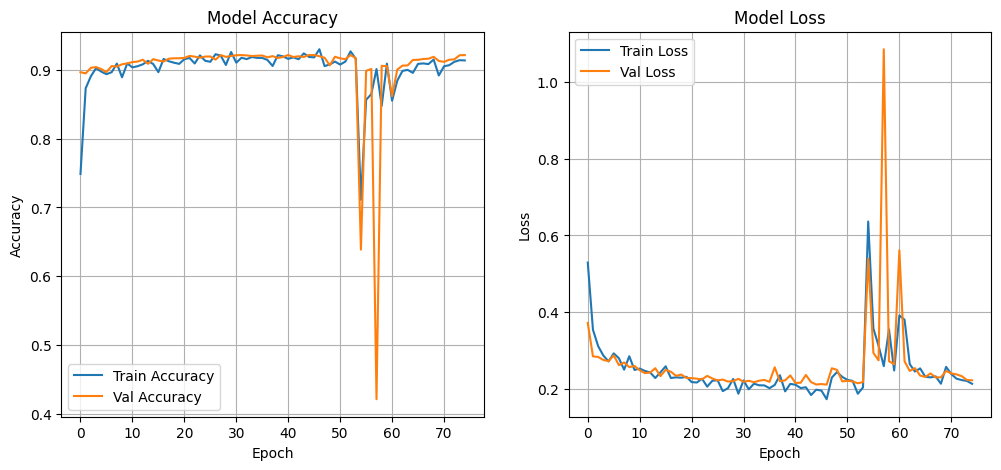

In [46]:

# Plot accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

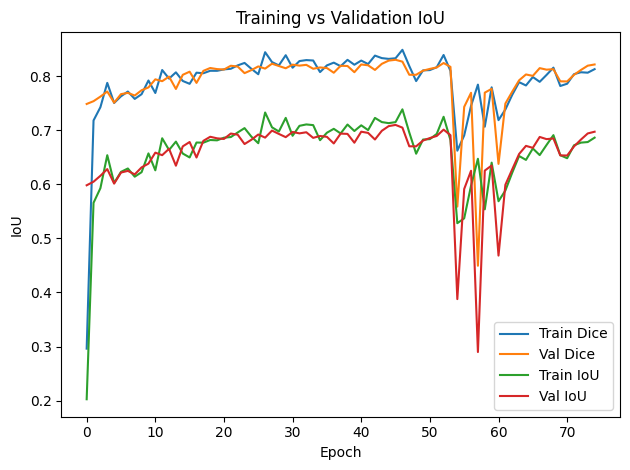

In [47]:
# Extract training history
history_dict = history.history

# Plot Dice Coefficient
plt.plot(history_dict['dice_coef'], label='Train Dice')
plt.plot(history_dict['val_dice_coef'], label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.title('Training vs Validation Dice')

# Plot IoU
plt.plot(history_dict['iou_metric'], label='Train IoU')
plt.plot(history_dict['val_iou_metric'], label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('Training vs Validation IoU')

plt.tight_layout()
plt.show()


## Key Results

- **Validation Accuracy** stabilized around 92%.

- **Dice coefficient** (Val Dice) reached about 0.82, showing good overlap between predictions and ground-truth masks.

- **IoU** (Val IoU) reached about 0.70, indicating that the model is learning meaningful boundaries.

- **validation loss** decreased steadily to ~0.21, with early signs of overfitting mitigated by augmentation and checkpointing.